# Pytorch Model Deployment

Author: Ross Hunter

Date: 2025-10-07

## Resources:

Lesson Textbook:
https://www.learnpytorch.io/09_pytorch_model_deployment/#0-getting-setup

Github:
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb

Slides:
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf

## Setup

In [17]:
import platform
os_name = platform.system()
print(f"Operating System: {os_name}")

Operating System: Windows


In [18]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) >= 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13 or int(torchvision.__version__.split(".")[0]) >= 1, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:    
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    if os_name == "Windows":
        print(f"Running commands for OS: : {os_name}")
        # TODO: add Windows version of the commands here.
        # Base them on WSL Windows Linux Subsystem
    else:
        print(f"Running commands for OS: {os_name}")
        !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1
torchvision version: 0.20.1


In [19]:
# Continue with regular imports
import matplotlib.pyplot as plt
#import torch
#import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    if os_name == "Windows":
        !conda install -q torchinfo
    else:
        !pip install -q torchinfo
        from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    if os_name == "Windows":
        print(f"Running commands for OS: : {os_name}")
    else:
        print(f"Running commands for OS: : {os_name}")
        !git clone https://github.com/mrdbourke/pytorch-deep-learning
        !mv pytorch-deep-learning/going_modular .
        !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
        !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model:

Pizza, steak, sushi dataset.

In [21]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [22]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2 FoodVision Mini model deployment experiment outline

### Questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.
* Performs with 95%+ accuracy
* Fast: as close to real-time (or faster) (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place.

Models: EffNetB2, ViT

Get metrics on the models and compare them. Choose the best model for the use case.and

Two experiments:
1. EffNetB2 feature extractor ( just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)




## 3. Creating an EffNetB2 feature extractor.

Feature extractor - a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html

In [23]:
import torchvision
from torchinfo import summary
from typing import Tuple

def create_effnetb2_model(num_classes: int = 3, seed: int = 42) -> Tuple[torch.nn.Module, torchvision.transforms._presets.ImageClassification]:

  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # DEFAULT == best available

  # 2. Get EffNetB2 transforms - for getting our data into the same format that the original model was trained on.
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance. It's also possible to use weights="DEFAULT" if you want to skip getting the weights in step #1
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False # prevent params from being updated by gradient descent in our training loop.

  # 5. Set seeds for reproducibility
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # update the classifier layer to make it trainable
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features = 1408, out_features=num_classes)
  )

  return effnetb2, effnetb2_transforms

Fine tuning: we wouldn't freeze all layers in the base model, we would tune some of them to our own custom data.

Feature extractor: just leave the top layers trainable.

In [24]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [25]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [26]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [27]:
# Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2,
#        input_size=(1, 3, 244, 244),
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

### Creating DataLoaders for EffNetB2

In [28]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=32)

In [29]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### Training EffNetB2 feature extractor

In [30]:
from going_modular.going_modular.engine import train

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer NOTE 2025-10-07: I just realized that I used
# the wrong lr (learning rate) value, 0.1. It should have
# been 1e-3. That's why the results came out really bad,
# it was overcorrecting on the optimizer step.
optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

# Training function (engine.py)
# imported above

In [31]:
# Set seeds for reproducibility and train the model.
set_seeds()
training_results_v0 = train(model=effnetb2,
      train_dataloader=train_dataloader_effnetb2,
      test_dataloader=test_dataloader_effnetb2,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9832 | train_acc: 0.5729 | test_loss: 0.7374 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7092 | train_acc: 0.8438 | test_loss: 0.5865 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5852 | train_acc: 0.9000 | test_loss: 0.4871 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4469 | train_acc: 0.9062 | test_loss: 0.4341 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4216 | train_acc: 0.9125 | test_loss: 0.3886 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4397 | train_acc: 0.8854 | test_loss: 0.3500 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4297 | train_acc: 0.8667 | test_loss: 0.3251 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3805 | train_acc: 0.9042 | test_loss: 0.3457 | test_acc: 0.9318
Epoch: 9 | train_loss: 0.3748 | train_acc: 0.8896 | test_loss: 0.3122 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3692 | train_acc: 0.8604 | test_loss: 0.2792 | test_acc: 0.9688


In [32]:
training_results_v0

{'train_loss': [0.9832229693730672,
  0.7091799815495808,
  0.5852022806803385,
  0.4469022144873937,
  0.42164493203163145,
  0.4397339701652527,
  0.42968730330467225,
  0.38051337997118634,
  0.3748067071040471,
  0.36915046274662017],
 'train_acc': [0.5729166666666666,
  0.84375,
  0.9,
  0.90625,
  0.9125,
  0.8854166666666666,
  0.8666666666666667,
  0.9041666666666667,
  0.8895833333333333,
  0.8604166666666667],
 'test_loss': [0.7373863816261291,
  0.5864576816558837,
  0.48707672357559206,
  0.4341265559196472,
  0.388616019487381,
  0.35001319646835327,
  0.32508150339126585,
  0.34569818079471587,
  0.31218922734260557,
  0.2792456090450287],
 'test_acc': [0.934659090909091,
  0.934659090909091,
  0.95625,
  0.940909090909091,
  0.9289772727272727,
  0.96875,
  0.95625,
  0.9318181818181819,
  0.9255681818181818,
  0.96875]}

** Note ** - Data augmentation can help prevent overfitting.

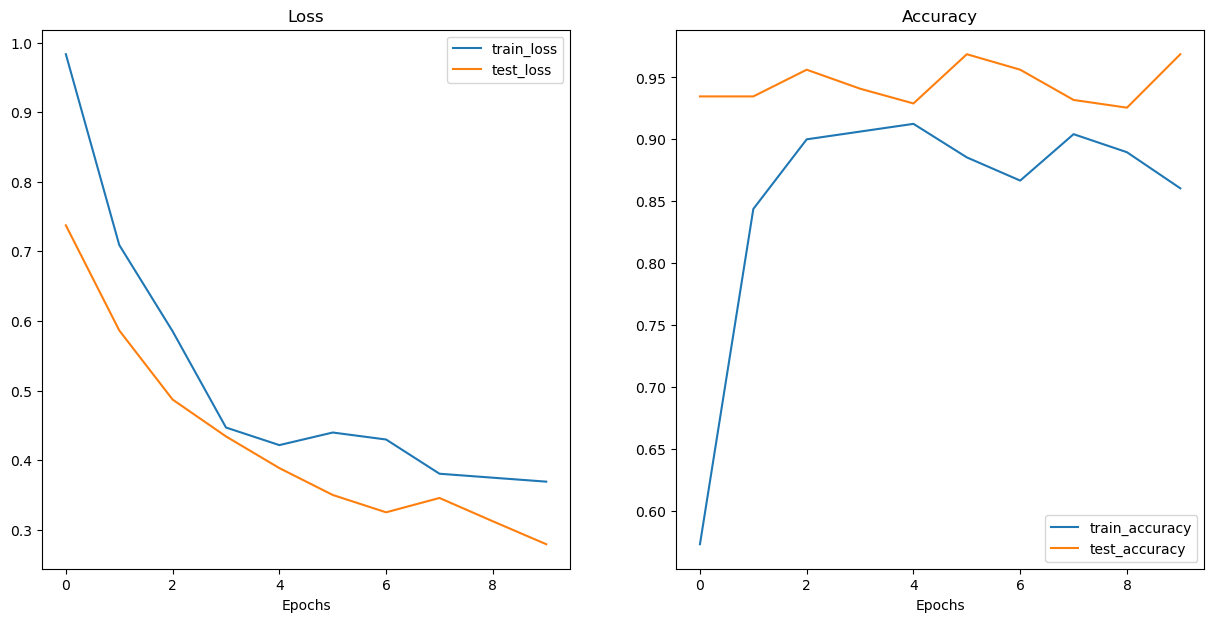

In [33]:
plot_loss_curves(training_results_v0)

### Saving EffNetB2 feature extractor

In [34]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### Inspecting the size of our EffNetB2 feature extractor

* If the model is too large, we may not be able to store or run it on our target device.

In [35]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained model size in megabytes: {round(pretrained_effnetb2_model_size, 2):.2f}")

Pretrained model size in megabytes: 29.86


### Collecting EffNetB2 Feature Extractor Stats

In [36]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [37]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": training_results_v0["test_loss"][-1],
                  "test_acc": training_results_v0["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2792456090450287,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

## Creating a ViT feature extractor

Instantiate the ViT model


In [38]:
import torchvision
from torchinfo import summary
from typing import Tuple

def create_vit_model(num_classes: int = 3, seed: int = 42) -> Tuple[torch.nn.Module, torchvision.transforms._presets.ImageClassification]:

  # 1. Setup pretrained model weights
  model_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT == best available

  # 2. Get model transforms - for getting our data into the same format that the original model was trained on.
  model_transforms = model_weights.transforms()

  # 3. Setup pretrained model instance. It's also possible to use weights="DEFAULT" if you want to skip getting the weights in step #1
  model = torchvision.models.vit_b_16(weights=model_weights).to(device)

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False # prevent params from being updated by gradient descent in our training loop.

  # 5. Set seeds for reproducibility
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # update the classifier layer to make it trainable
  model.heads = nn.Sequential(
    # It appears as though the original ViT model didn't have a dropout layer.
    nn.Linear(in_features = 768, out_features=num_classes, bias=True)
  )

  return model, model_transforms

In [39]:
vitb16, vitb16_transforms = create_vit_model()

### Creating DataLoaders for ViT

In [40]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vitb16, test_dataloader_vitb16, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=vitb16_transforms, batch_size=32)

In [41]:
len(train_dataloader_vitb16), len(test_dataloader_vitb16), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### Training ViT feature extractor

In [42]:
from going_modular.going_modular.engine import train

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(vitb16.parameters(), lr=1e-3)

# Training function (engine.py)
# imported above

In [43]:
vitb16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [44]:
vitb16_training_results_v0 = train(model=vitb16,
      train_dataloader=train_dataloader_vitb16,
      test_dataloader=test_dataloader_vitb16,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5952 | train_acc: 0.8063 | test_loss: 0.2576 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2045 | train_acc: 0.9417 | test_loss: 0.1341 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1820 | train_acc: 0.9229 | test_loss: 0.1062 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1599 | train_acc: 0.9604 | test_loss: 0.1034 | test_acc: 0.9631
Epoch: 5 | train_loss: 0.1070 | train_acc: 0.9688 | test_loss: 0.0972 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0918 | train_acc: 0.9750 | test_loss: 0.0853 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.1316 | train_acc: 0.9479 | test_loss: 0.0801 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0740 | train_acc: 0.9854 | test_loss: 0.0850 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0811 | train_acc: 0.9917 | test_loss: 0.0781 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0582 | train_acc: 0.9917 | test_loss: 0.0707 | test_acc: 0.9722


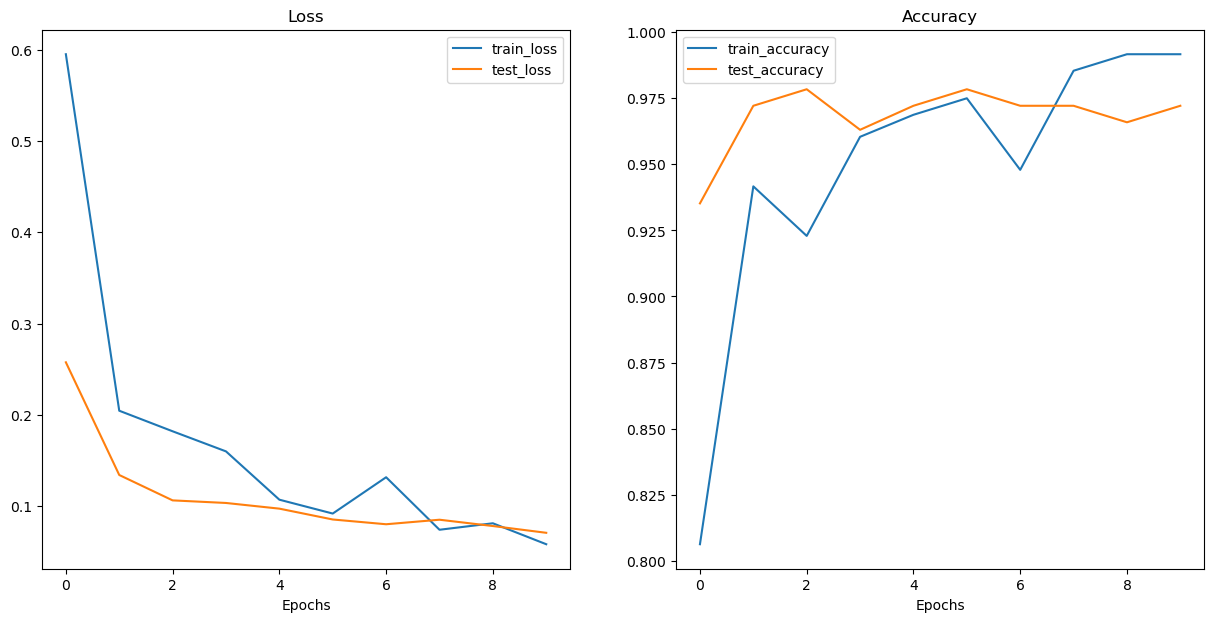

In [45]:
plot_loss_curves(vitb16_training_results_v0)

### Saving ViT feature extractor

In [46]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vitb16,
                 target_dir="models",
                 model_name="09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth


### Inspecting the size of ViT feature extractor

In [47]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vitb16_model_size = Path("models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained model size in megabytes: {round(pretrained_vitb16_model_size, 2):.2f}")

Pretrained model size in megabytes: 327.37


### Collecting ViT feature extractor stats

In [48]:
# Count number of parameters in vitb16
vitb16_total_params = sum(torch.numel(param) for param in vitb16.parameters())
vitb16_total_params

85800963

In [49]:
# Create a dictionary with vitb16 statistics
vitb16_stats = {"test_loss": vitb16_training_results_v0["test_loss"][-1],
                  "test_acc": vitb16_training_results_v0["test_acc"][-1],
                  "number_of_parameters": vitb16_total_params,
                  "model_size (MB)": pretrained_vitb16_model_size}
vitb16_stats

{'test_loss': 0.07071373825892806,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3714771270752}

## Making predictions with our trained models and timing them

loop over the test data and keep track of the time per prediction so we can average it at the end and get the average time per prediction for each model.

In [50]:
from going_modular.going_modular.engine import test_step
import time

# prep data into batches of 1 for real world test simulation
# Setup DataLoader
from going_modular.going_modular import data_setup
dataloader_effnetb2_train, dataloader_effnetb2_production, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=1)

effnetb2_prediction_times = []

# Loop over data and get prediction times for effnetb2
effnetb2.eval()
with torch.inference_mode():
  for X, y in dataloader_effnetb2_production:
    start_time = time.time()
    X, y = X.to(device), y.to(device)
    raw_logits = effnetb2(X)
    test_pred_labels = raw_logits.argmax(dim=1)
    end_time = time.time()
    computation_time = end_time - start_time
    effnetb2_prediction_times.append(computation_time)

effnetb2_average_prediction_time = sum(effnetb2_prediction_times) / len(effnetb2_prediction_times)
print(f"EffNetB2 average prediction time: {effnetb2_average_prediction_time}")

EffNetB2 average prediction time: 0.02815257708231608


In [51]:
# Loop over data and get prediction time for vit
import time

# Setup DataLoader
from going_modular.going_modular import data_setup
dataloader_vit_train, dataloader_vit_production, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=vitb16_transforms, batch_size=1)

vit_prediction_times = []

vitb16.eval()
with torch.inference_mode():
  for X, y in dataloader_vit_production:
    start_time = time.time()
    X, y = X.to(device), y.to(device)
    raw_logits = vitb16(X)
    test_pred_labels = raw_logits.argmax(dim=1)
    end_time = time.time()
    computation_time = end_time - start_time
    vit_prediction_times.append(computation_time)

vit_average_prediction_time = sum(vit_prediction_times) / len(vit_prediction_times)
print(f"ViT average prediction time: {vit_average_prediction_time}")

ViT average prediction time: 0.023979458808898926


In [52]:
print(f"EffNetB2 # of samples: {len(dataloader_effnetb2_production)}")
print(f"ViT # of samples: {len(dataloader_vit_production)}")
print(f"EffNetB2 average prediction time: {round(effnetb2_average_prediction_time, 3)}")
print(f"ViT average prediction time: {round(vit_average_prediction_time, 3)}")

EffNetB2 # of samples: 150
ViT # of samples: 150
EffNetB2 average prediction time: 0.028
ViT average prediction time: 0.024


### Make a `pred_and_store()` function

Steps: to create `pred_and_store()`

1. Create a function that takes a list of paths and a trained PyTorch, a series of transforms, a list of target class names, and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground trugh class from the filepath.
6. Start the prediction timer
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate prediction probabilities + prediction class.
11. Add the prediction probability + prediction class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [53]:
test_dir

WindowsPath('data/pizza_steak_sushi_20_percent/test')

In [54]:
# from pathlib import Path

# # Get all test data paths
# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_data_paths[:1]

# # Create an empty dictionary for each sample (prediction statistics will go in here).
# str(test_data_paths[0]).split("/")[-2]

In [55]:
# take in: a list of paths (images)
# a trained PyTorch
# a series of transforms
# a list of target class names
# a target device
import pathlib
from tqdm.auto import tqdm
from typing import List, Dict
from PIL import Image

# Get all test data paths
# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

def pred_and_store(image_list: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  prediction_list = []

  for path in tqdm(test_data_paths):
    # Create an empty dictionary for each sample (prediction statistics will go in here).
    prediction_dict = {}
    # Get the sample path and ground truth class from the filepath.
    full_sample_path = str(path)
    truth_class_name = path.parent.stem    

    # Start the prediction timer
    start_time = time.time() # could also use `timer()`

    # Open the image using PIL.Image.open(path)
    sample_image = Image.open(full_sample_path)

    # Transform the image to be usable with a given model. Unsqueeze at the 0th dimension to add a dimension (working with single image instead of a batch so add a dimension because our model was trined on batches and is used to that tensor shape)
    transformed_image = transform(sample_image).unsqueeze(dim=0).to(device)

    # Prepare the model for inference by sending it to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # Turn on torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate prediction probabilities + prediction class.
    with torch.inference_mode():
      raw_logit = model(transformed_image)
      pred_prob = torch.softmax(raw_logit, dim=1) # turn the logit into prediction probability
      pred_label = torch.argmax(pred_prob, dim=1) # get the pred index with the max value
      pred_class = class_names[pred_label.cpu()] # the python variables are on CPU so do the comparison on CPU.

    # Add the prediction probability + prediction class to empty dictionary from step 4.
    prediction_dict["prediction_probability"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4) # convert the tensor to an int.
    prediction_dict["prediction_class"] = pred_class

    # End the prediction timer started in step 6 and add the time to the prediction dictionary.
    end_time = time.time()
    computation_time = end_time - start_time
    prediction_dict["time_for_pred"] = round(computation_time, 4)

    # See if the predicted class matches the ground truth class.
    prediction_dict["correct"] = truth_class_name == pred_class

    # Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    prediction_list.append(prediction_dict)

  # Return the list of prediction dictionaries.
  return prediction_list

### Get prediction stats for the EffNetB2 model

In [56]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

effnetb2_full_pred_stats = pred_and_store(test_data_paths,
                   effnetb2,
                   effnetb2_transforms,
                   class_names,
                   device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [57]:
effnetb2_full_pred_stats[:2]

[{'prediction_probability': 0.9948,
  'prediction_class': 'pizza',
  'time_for_pred': 0.0425,
  'correct': True},
 {'prediction_probability': 0.4761,
  'prediction_class': 'pizza',
  'time_for_pred': 0.039,
  'correct': True}]

In [58]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_full_pred_stats)
effnetb2_test_pred_df.head()

,prediction_probability,prediction_class,time_for_pred,correct
0,0.9948,pizza,0.0425,True
1,0.4761,pizza,0.0390,True
2,0.9919,pizza,0.0390,True
3,0.7047,pizza,0.0435,True
4,0.7635,pizza,0.0370,True


In [59]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [60]:
# Find the average time per prediction
effnetb2_average_time_per_prediction = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"effnetb2 average time per prediction: {effnetb2_average_time_per_prediction}")

effnetb2 average time per prediction: 0.0353


In [61]:
effnetb2_stats["time_per_pred_gpu"] = float(effnetb2_average_time_per_prediction)

In [62]:
effnetb2_stats

{'test_loss': 0.2792456090450287,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_gpu': 0.0353}

### Get prediction stats for the ViT (vitb16) model

In [63]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

vitb16_full_pred_stats = pred_and_store(test_data_paths,
                   vitb16,
                   vitb16_transforms,
                   class_names,
                   device) # could hard code "cpu"

  0%|          | 0/150 [00:00<?, ?it/s]

In [64]:
vitb16_full_pred_stats[:2]

[{'prediction_probability': 0.999,
  'prediction_class': 'pizza',
  'time_for_pred': 0.0605,
  'correct': True},
 {'prediction_probability': 0.9971,
  'prediction_class': 'pizza',
  'time_for_pred': 0.058,
  'correct': True}]

In [65]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vitb16_test_pred_df = pd.DataFrame(vitb16_full_pred_stats)
vitb16_test_pred_df.head()

,prediction_probability,prediction_class,time_for_pred,correct
0,0.9990,pizza,0.0605,True
1,0.9971,pizza,0.0580,True
2,0.9991,pizza,0.0605,True
3,0.9894,pizza,0.0545,True
4,0.9797,pizza,0.0570,True


In [66]:
# Check number of correct predictions
vitb16_test_pred_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [67]:
# Find the average time per prediction
vitb16_average_time_per_prediction = round(vitb16_test_pred_df.time_for_pred.mean(), 4)
print(f"vitb16 average time per prediction: {vitb16_average_time_per_prediction}")

vitb16 average time per prediction: 0.0344


In [68]:
vitb16_stats["time_per_pred_gpu"] = float(vitb16_average_time_per_prediction)

In [69]:
vitb16_stats

{'test_loss': 0.07071373825892806,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3714771270752,
 'time_per_pred_gpu': 0.0344}

## Comparing model results, prediction time, and size

In [70]:
# Add column for model names
df = pd.DataFrame([effnetb2_stats, vitb16_stats])

# Add column for model names
df["model"] = ["EffNetB2","ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_gpu,model
0,0.279246,96.88,7705221,29.863886,0.0353,EffNetB2
1,0.070714,97.22,85800963,327.371477,0.0344,ViT


In [71]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
    columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_gpu
ViT to EffNetB2 ratios,0.253231,1.003509,11.135432,10.962119,0.974504


### Visualizing the speed vs. performace tradeoff

So, we've compared our EffNetB2 and ViT feature extractor model, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
    1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
    2. Add titles and labels to make our plot look nice.
    3. Annotate the samples on the scatter plot so we know what's going on.
    4. Create a legend based on the model sizes (`model_size` (MB)).

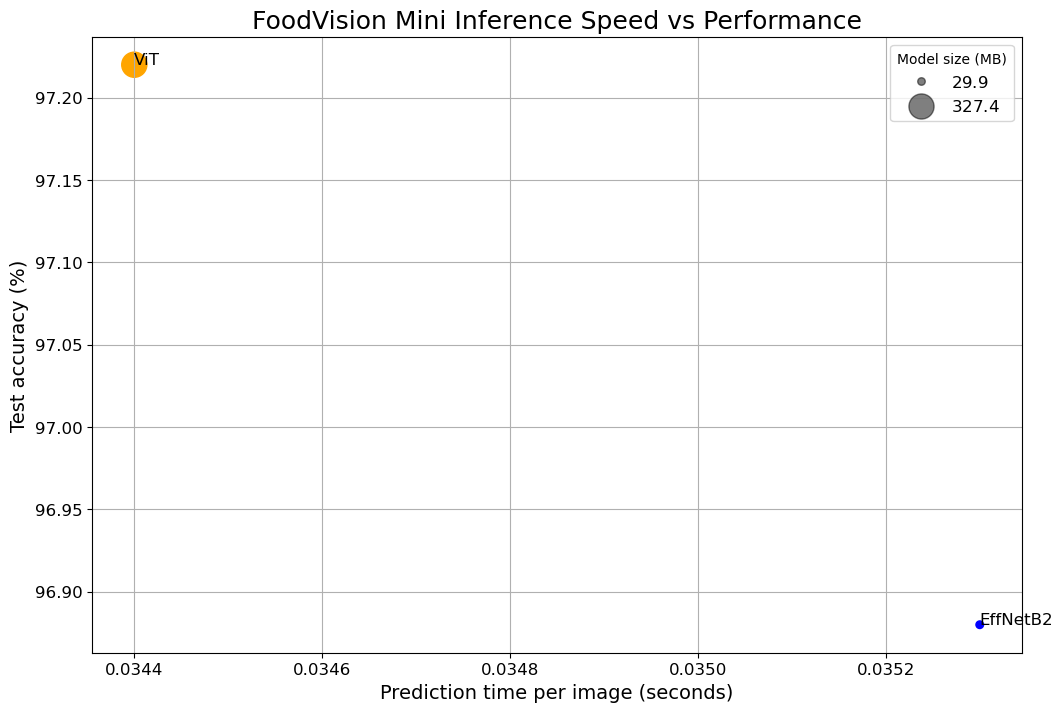

In [72]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_gpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
               xy=(row["time_per_pred_gpu"], row["test_acc"]),
               size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                             labels,
                             loc="upper right",
                             title="Model size (MB)",
                              fontsize=12)
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## Brining FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfills our criteria the best.

Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
https://www.gradio.app/



## Creating a function to map our inputs and outputs

In [73]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [74]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = time.time()
    
    # Transform the input image for use with EffNetB2
    image_with_transform = effnetb2_transforms(img).unsqueeze(0) # unsqueeze to add a batch dimension
    
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(image_with_transform), dim=1) # turn the logit into prediction probability        
        pred_label = torch.argmax(pred_probs, dim=1) # get the pred index with the max value
        pred_class = class_names[pred_label.cpu()]
        
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = time.time()
    prediction_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, prediction_time

In [75]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\sushi\715227.jpg

{'pizza': 0.1690986007452011, 'steak': 0.08635904639959335, 'sushi': 0.7445423007011414}
0.1285


### Creating a list of example images

In [76]:
#Create a list of example input to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\sushi\\3365273.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\pizza\\724290.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1882831.jpg']]

### Build a Gradio Interface

Use `gr.Interface()` - https://www.gradio.app/docs/gradio/interface

In [77]:
#!pip install gradio

In [78]:
import gradio as gr

title = "FoodVision Mini"
description = "An efficient model for recognizing photos of pizza, steak, and sushi."
article = "Created at 09 PyTorch Model Deployment"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediction time(s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)
# demo.launch()

## What is Hugging Face Spaces?

> Hugging Face Spaces make it easy for you to create and deploy ML-powered demos in minutes.

Hugging Face Spaces is like the Github of the ML world. Great for sharing your projects with the rest of the world and building up a portfolio.

> Note: There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.

### Deployed Gradio app structure

Spaces stores your code inside a Git repository. Supports git and git-lfs.

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### Create the Gradio project structure for deployment to Hugging Face

In [87]:
import shutil
from pathlib import Path
import platform
import os

os_name = platform.system()
# print(f"Operating System: {os_name}")

foodvision_mini_demo_path = Path("demos/foodvision_mini/")
foodvision_mini_demo_examples_path = Path("demos/foodvision_mini/examples")

# Create the /demos/foodvision_mini/ path.
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                   exist_ok=True)    
else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
# Make the rest of the directory structure
foodvision_mini_demo_examples_path.mkdir(parents=True, exist_ok=True)
# Copy the example files into the examples path.
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
    destination = foodvision_mini_demo_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination) # copy2 attempts to preserve file meta data.

# Create a list of lists for use in the Gradio script. It is going to require a list of lists that is based in the examples/ path dir.
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_demo_examples_path)]

# Copy the model file into foodvision_mini_demo_path
try:    
    effnetb2_model_source_path = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")
    effnetb2_model_dest_path = foodvision_mini_demo_path / effnetb2_model_source_path.name
    print(f"[INFO] Copying {effnetb2_model_source_path} to {effnetb2_model_dest_path}")
    shutil.copy2(src=effnetb2_model_source_path , dst=effnetb2_model_dest_path)
    print(f"[INFO] Finished copying {effnetb2_model_source_path} to {effnetb2_model_dest_path}")
except:
    print(f"[ERROR] Error copying {effnetb2_model_source_path} to {effnetb2_model_dest_path}")
    print(f"[INFO] Model {effnetb2_model_source_path} exists?: {os.path.exists(effnetb2_model_dest_path)}")


[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg
[INFO] Copying models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Finished copying models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [85]:
# Copy the model file into foodvision_mini_demo_path
# effnetb2_model_source_path = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")
# effnetb2_model_dest_path = foodvision_mini_demo_path / effnetb2_model_source_path.name
# effnetb2_model_dest_path

In [88]:
%%writefile demos/foodvision_mini/model.py

import torch
from torch import nn
import torchvision
from torchinfo import summary
from typing import Tuple

def create_effnetb2_model(num_classes: int = 3, seed: int = 42, device: str = "cpu") -> Tuple[torch.nn.Module, torchvision.transforms._presets.ImageClassification]:

  # 1. Setup pretrained EffNetB2 weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # DEFAULT == best available

  # 2. Get EffNetB2 transforms - for getting our data into the same format that the original model was trained on.
  effnetb2_transforms = effnetb2_weights.transforms()

  # 3. Setup pretrained model instance. It's also possible to use weights="DEFAULT" if you want to skip getting the weights in step #1
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False # prevent params from being updated by gradient descent in our training loop.

  # 5. Set seeds for reproducibility
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # update the classifier layer to make it trainable
  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features = 1408, out_features=num_classes)
  )

  return effnetb2, effnetb2_transforms

Overwriting demos/foodvision_mini/model.py


In [92]:
# Test to make sure the file saved properly
#from demos.foodvision_mini import model
#effnetb2_model_test, effnetb2_transforms_test = model.create_effnetb2_model()
#effnetb2_model_test


In [ ]:
# create app.py
%%writefile demos/foodvision_mini/app.py

# import model.py and set up model
import gradio as gr
from typing import Tuple, Dict
from demos.foodvision_mini import model

# model creation code
# Put our model on the CPU
effnetb2_model, effnetb2_transforms = model.create_effnetb2_model()
effnetb2_model = effnetb2_model.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

# Include Gradio app code
title = "FoodVision Mini"
description = "An efficient model for recognizing photos of pizza, steak, and sushi."
article = "Created at 09 PyTorch Model Deployment"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediction time(s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)
# demo.launch()

# a way to get the example list
#Create a list of example input to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
#example_list

# the prediction function
def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = time.time()
    
    # Transform the input image for use with EffNetB2
    image_with_transform = effnetb2_transforms(img).unsqueeze(0) # unsqueeze to add a batch dimension
    
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(image_with_transform), dim=1) # turn the logit into prediction probability        
        pred_label = torch.argmax(pred_probs, dim=1) # get the pred index with the max value
        pred_class = class_names[pred_label.cpu()]
        
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = time.time()
    prediction_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, prediction_time
